In [92]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


df = pd.read_csv('./data/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [93]:
# Подготовка данных по добыче
resources = df.groupby('API')[['Liquid', "Gas", "Water"]].apply(lambda df_: df_.reset_index(drop=True))
resources.head()

Liquid    Gas  Water
API                                  
5005072170100 0    9783  11470  10558
              1   24206  26476   5719
              2   20449  26381   2196
              3    6820  10390    583
              4    7349   7005    122

In [94]:
resources["Liquid"] /= resources["Liquid"].max()
resources["Gas"] /= resources["Gas"].max()
resources["Water"] /= resources["Water"].max()
resources.head()

Liquid       Gas     Water
API                                          
5005072170100 0  0.231031  0.104021  0.055490
              1  0.571638  0.240110  0.030058
              2  0.482914  0.239249  0.011542
              3  0.161058  0.094227  0.003064
              4  0.173551  0.063528  0.000641

In [95]:
resources.iloc[0]

Liquid    0.231031
Gas       0.104021
Water     0.055490
Name: (5005072170100, 0), dtype: float64

In [96]:
data = resources.to_numpy()
data = data.reshape((50, 24, 3))
data.shape

(50, 24, 3)

In [97]:
train = data[:40]
test = data[40:]
train.shape, test.shape

((40, 24, 3), (10, 24, 3))

In [98]:
x_data = [train[:, i:i+12] for i in range(11)]
y_data = [train[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [99]:
tensor_x = torch.Tensor(x_data) # transform to torch tensor
tensor_y = torch.Tensor(y_data)

oil_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
oil_dataloader = DataLoader(oil_dataset, batch_size=16) # create your dataloader

In [100]:
for x_t, y_t in oil_dataloader:
    break
x_t.shape, y_t.shape

(torch.Size([16, 12, 3]), torch.Size([16, 12, 3]))

In [101]:
class OilModel(nn.Module):
    def __init__(self, timesteps=12, units=32):
        super().__init__()
        self.lstm1 = nn.LSTM(3, units, 2, batch_first=True)
        self.dense = nn.Linear(units, 3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h, _ = self.lstm1(x)
        outs = []
        for i in range(h.shape[0]):
            outs.append(self.relu(self.dense(h[i])))
        #print(outs)
        out = torch.stack(outs, dim=0)
        return out

In [102]:
model = OilModel()
opt = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [109]:
NUM_EPOCHS = 1000

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    num = 0
    for x_t, y_t in oil_dataloader:
        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = model(x_t)
        loss = criterion(outputs, y_t)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        num += 1
        
    if epoch % 10 == 0:
        print(f'[Epoch: {epoch + 1:2d}] loss: {running_loss:.3f}')
        print(outputs.shape)
print('Finished Training')

[Epoch:  1] loss: 0.034
torch.Size([8, 12, 3])
[Epoch: 11] loss: 0.034
torch.Size([8, 12, 3])
[Epoch: 21] loss: 0.033
torch.Size([8, 12, 3])
[Epoch: 31] loss: 0.033
torch.Size([8, 12, 3])
[Epoch: 41] loss: 0.033
torch.Size([8, 12, 3])
[Epoch: 51] loss: 0.032
torch.Size([8, 12, 3])
[Epoch: 61] loss: 0.032
torch.Size([8, 12, 3])
[Epoch: 71] loss: 0.032
torch.Size([8, 12, 3])
[Epoch: 81] loss: 0.031
torch.Size([8, 12, 3])
[Epoch: 91] loss: 0.031
torch.Size([8, 12, 3])
[Epoch: 101] loss: 0.031
torch.Size([8, 12, 3])
[Epoch: 111] loss: 0.031
torch.Size([8, 12, 3])
[Epoch: 121] loss: 0.031
torch.Size([8, 12, 3])
[Epoch: 131] loss: 0.030
torch.Size([8, 12, 3])
[Epoch: 141] loss: 0.030
torch.Size([8, 12, 3])
[Epoch: 151] loss: 0.029
torch.Size([8, 12, 3])
[Epoch: 161] loss: 0.029
torch.Size([8, 12, 3])
[Epoch: 171] loss: 0.029
torch.Size([8, 12, 3])
[Epoch: 181] loss: 0.029
torch.Size([8, 12, 3])
[Epoch: 191] loss: 0.028
torch.Size([8, 12, 3])
[Epoch: 201] loss: 0.029
torch.Size([8, 12, 3])
[E

In [110]:
x_tst = test[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))
print(x_tst.shape)

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    x_t = torch.from_numpy(x).float()
    print(x_t.shape)
    pred = model(x_t).detach().numpy()
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)
predicts

(10, 12, 3)
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])
torch.Size([10, 12, 3])


array([[[4.52034473e-02, 2.41833180e-01, 0.00000000e+00],
        [2.93230582e-02, 2.86181897e-01, 0.00000000e+00],
        [5.28873354e-02, 2.74009526e-01, 0.00000000e+00],
        [4.12218422e-02, 1.86668560e-01, 0.00000000e+00],
        [7.72136450e-02, 3.00048828e-01, 0.00000000e+00],
        [6.11167550e-02, 3.99062365e-01, 7.52562517e-03],
        [1.10639371e-01, 4.84422892e-01, 8.41401983e-04],
        [1.49251670e-01, 4.53808457e-01, 0.00000000e+00],
        [8.44201297e-02, 4.03852493e-01, 0.00000000e+00],
        [4.47232649e-02, 4.53244656e-01, 0.00000000e+00],
        [1.81473885e-02, 3.35109472e-01, 0.00000000e+00],
        [4.95689437e-02, 3.77356559e-01, 0.00000000e+00]],

       [[3.83487754e-02, 8.15557837e-02, 0.00000000e+00],
        [2.33178325e-02, 8.70682448e-02, 0.00000000e+00],
        [1.88533086e-02, 1.00822113e-01, 1.70792872e-03],
        [2.45858971e-02, 1.06051788e-01, 2.76532071e-03],
        [2.30636355e-02, 9.92126912e-02, 1.92509731e-03],
        [2.1

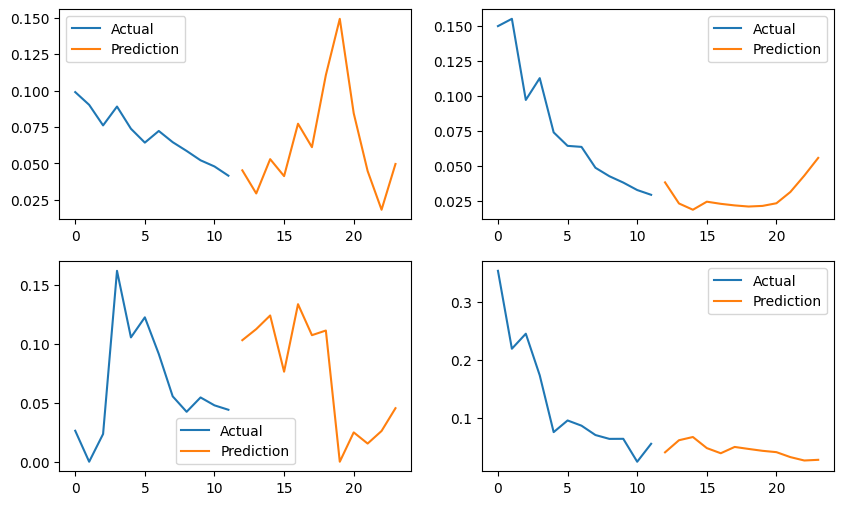

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()

# Задание
2. Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т.е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas и Water (для дальнейшего предсказания). Графики с результатами только для Liquid.